In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
from PIL import Image
import torchvision
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from torch.utils.data import random_split
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from pathlib import Path
import pathlib
import inspect
import random
import gc

In [ ]:
root_path = Path().resolve().parent
train = pd.read_csv(root_path / 'train.csv')
test = pd.read_csv(root_path / 'test.csv')
image_path = root_path / 'images'
checkpoint_path = 'data_augmentation.pth'

In [33]:
class plantDataset(Dataset):
    def __init__(self, image_dir, csv: dict, class_names: list, transform=None, is_test: bool=None):
        self.image_dir = image_dir
        self.class_names = class_names
        self.transform = transform
        self.is_test = is_test
        self.csv = csv

    def __getitem__(self, index):
        csv = self.csv
        row = csv.iloc[index]
        image_id = row['image_id']+'.jpg'
        image_path = Path(self.image_dir) / image_id
        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img, image_id.split('.')[0]
        
        else:
            one_hot = self.getLabels(index, csv, self.class_names)
            label = torch.tensor(one_hot).argmax().long()
            return img, label
    
    def __len__(self):
        return len(self.csv['image_id'])
    
    
    def getLabels(self, n, csv: dict, class_names) -> np.array:
        return csv.iloc[n][class_names].values.astype(np.float32)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [35]:
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
train_dataset = plantDataset(image_path, train.iloc[:1456].reset_index(drop=True), class_names, transform)
val_dataset = plantDataset(image_path, train.iloc[1456:].reset_index(drop=True), class_names, transform)
test_dataset = plantDataset(image_path, test, class_names, transform, is_test=True)

In [36]:
type(train_dataset)

__main__.plantDataset

In [37]:
class Augment():
    # def __init__(self, dataset, dataBalence: bool=True, targetLabel: int=None, num: int=None):
    #     self.dataset = dataset
    #     self.targetLabel = targetLabel
    #     self.dataBalence = dataBalence
    #     if dataBalence == True and targetLabel != None or dataBalence == True and num != None:
    #         raise ""
    def dataBalance(self, dataset, dealFuncList: list):
        class_count = torch.tensor([0, 0, 0, 0])
        for _, label in dataset:
            class_count[label] += 1
        max_num = max(class_count)
        remain_num = max_num-class_count
        repeat_times = (max_num / class_count).int()

        augment_dataset = []
        for img, label in dataset:
            if remain_num[label] == 0:
                continue
            deal_imgs = self.deal_images(img, repeat_times[label], dealFuncList)
            for img in deal_imgs:
                augment_dataset.append((img, label))
            remain_num[label] -= 1
        return augment_dataset
    

    def deal_images(self, img, times: int, dealFuncList: list):
        dealFuncList = dealFuncList.copy()
        deal_imgs = []
        while times!=0 and len(dealFuncList)!=0:
            transform = random.choice(dealFuncList)
            dealFuncList.remove(transform)
            deal_imgs.append(transform(img))
        return deal_imgs

In [38]:
dealFuncList = [torchvision.transforms.RandomHorizontalFlip(1), 
                        torchvision.transforms.RandomVerticalFlip(1), 
                        torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(1), torchvision.transforms.RandomVerticalFlip(1)])]
augment_dataset = Augment().dataBalance(train_dataset, dealFuncList)

In [39]:
train_dataset += augment_dataset

In [40]:
def data_weight(dataset):
    labels = []
    # class_count = [0, 0, 0, 0]
    for data in dataset:
        label = data[1]
        # class_count[label] += 1
        labels.append(label)
    # weight_per_class = 1.0 / torch.tensor(class_count).float()
    weight_per_class = torch.tensor([0.004, 0.002, 0.004, 0.004])
    weights = [weight_per_class[label] for label in labels]
    return torch.DoubleTensor(weights)
train_dataWeight = data_weight(train_dataset)
train_sampler = WeightedRandomSampler(
    weights=train_dataWeight,
    num_samples=len(train_dataWeight),
    replacement=True
)


In [41]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=2,
    sampler=train_sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

In [42]:
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=16,
#     shuffle=True,
#     num_workers=2
# )
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=16,
#     shuffle=False,
#     num_workers=2
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=16,
#     shuffle=False,
#     num_workers=2
# )

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [44]:
model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.classifier[1].in_features, 4))
model = model.to(device)

/home/willy/miniforge3/envs/pytorch2_7/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/willy/miniforge3/envs/pytorch2_7/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 0.9101, Val Loss: 0.4147
Epoch 2/15, Train Loss: 0.3671, Val Loss: 0.2636
Epoch 3/15, Train Loss: 0.1936, Val Loss: 0.2449
Epoch 4/15, Train Loss: 0.1503, Val Loss: 0.2311
Epoch 5/15, Train Loss: 0.1267, Val Loss: 0.2080
Epoch 6/15, Train Loss: 0.1012, Val Loss: 0.1809
Epoch 7/15, Train Loss: 0.0746, Val Loss: 0.1951
Epoch 8/15, Train Loss: 0.0665, Val Loss: 0.2040
Epoch 9/15, Train Loss: 0.0515, Val Loss: 0.2332
Epoch 10/15, Train Loss: 0.0738, Val Loss: 0.2847
Epoch 11/15, Train Loss: 0.0289, Val Loss: 0.2510
Epoch 12/15, Train Loss: 0.0390, Val Loss: 0.2687
Epoch 13/15, Train Loss: 0.0231, Val Loss: 0.2308
Epoch 14/15, Train Loss: 0.0320, Val Loss: 0.1847
Epoch 15/15, Train Loss: 0.0347, Val Loss: 0.2169


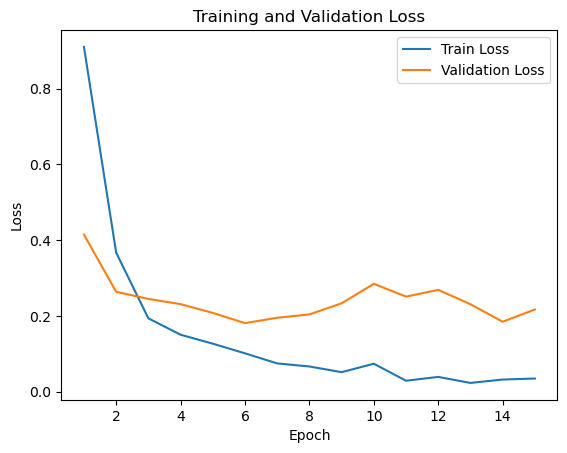

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
num_epochs = 15
best_val_loss = float('inf')

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), checkpoint_path)

    scheduler.step(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [46]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [47]:
test_predictions = []
test_ids = []
class_count = [0, 0, 0, 0]

with torch.no_grad():
    for inputs, image_ids in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).cpu()
        preds_class = torch.argmax(preds, dim=1).numpy().tolist()
        for idx in preds_class:
            class_count[idx] += 1 
        # print(preds)
        test_predictions.append(preds.numpy())
        test_ids.extend(image_ids)

test_predictions = np.concatenate(test_predictions, axis=0)
# print(test_predictions)

submission_df = pd.DataFrame({'image_id': test_ids})
for i, class_name in enumerate(class_names):
    submission_df[class_name] = test_predictions[:, i]

submission_df.to_csv('submission.csv', index=False)
print("Class Count:", class_count)

Testing: 100%|██████████| 114/114 [00:20<00:00,  5.61it/s]

Class Count: [377, 220, 638, 586]


<BarContainer object of 4 artists>

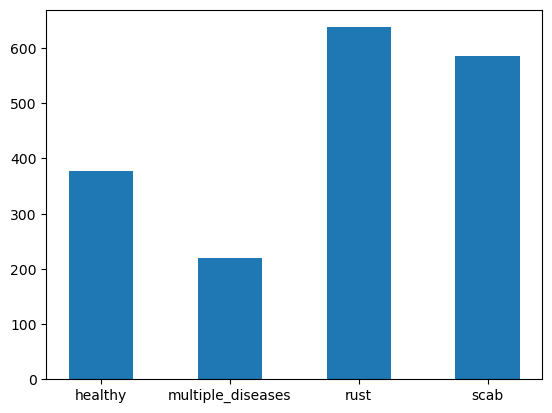

In [48]:
x = ['healthy', 'multiple_diseases', 'rust', 'scab']
y = class_count
plt.bar(x, y, width=0.5)

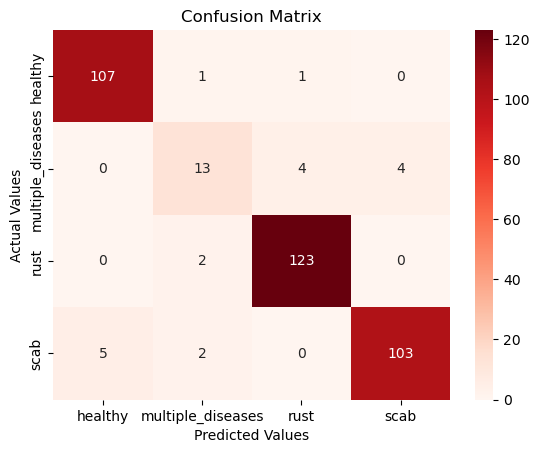

In [49]:
train_predictions = []
train_labels = []
with torch.no_grad():
    for n, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        preds_class = torch.argmax(preds, dim=1).cpu().numpy()
        labels_class = labels.numpy()
        train_predictions.append(preds_class)
        train_labels.append(labels_class)
train_predictions = np.concatenate(train_predictions, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
# print(train_predictions)
# print(train_labels)
cm = confusion_matrix(train_labels, train_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()



In [50]:
del model
torch.cuda.empty_cache()
gc.collect()

5879